# Práctica 3: Clasificación con scikit-learn

## Importar módulos

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing, model_selection, neighbors, svm, tree, ensemble

## Seleccionar datasets

Los conjuntos de datos seleccionados se encuentran en el directorio `datasets`.

In [2]:
accent_df = pd.read_csv('datasets/accent.csv', header=0)
avila_df = pd.read_csv('datasets/avila.csv', header=0)
cancer_df = pd.read_csv('datasets/cancer.csv', header=0, na_values='?')
digits_df = pd.read_csv('datasets/digits.csv', header=None)
fertility_df = pd.read_csv('datasets/fertility.csv', header=0)
glass_df = pd.read_csv('datasets/glass.csv', header=0)
iris_df = pd.read_csv('datasets/iris.csv', header=None)
column_df = pd.read_csv('datasets/column.csv', header=0)
phishing_df = pd.read_csv('datasets/phishing.csv', header=None)
wine_df = pd.read_csv('datasets/wine.csv', header=0)

### Preprocesamiento
Aplicamos el mismo que en la práctica anterior, además de eliminar de Avila y Glass las clases con menos de 10 instancias para poder realizar 10-fold estratificado

In [3]:
accent_df = accent_df[accent_df.columns.to_list()[1:]+[accent_df.columns.to_list()[0]]]

In [4]:
cancer_df = cancer_df.drop('id', axis=1)

In [5]:
cancer_df.bare_nuclei = cancer_df.bare_nuclei.fillna(np.mean(cancer_df.bare_nuclei)).astype('int')

In [6]:
avila_df = avila_df[avila_df['class'] != 'B']
glass_df = glass_df[glass_df['class'] != 6]

In [7]:
dfs = [accent_df, avila_df, cancer_df, digits_df, fertility_df, glass_df, iris_df, column_df, phishing_df, wine_df]
df_names = ['Accents', 'Avila', 'Cancer', 'Digits', 'Fertility', 'Glass', 'Iris', 'Vertebral Column', 'Phishing', 'Wine'] 

In [8]:
for df in dfs:
    df.iloc[:,-1] = df.iloc[:,-1].astype('category')

In [9]:
X = [df.iloc[:, :-1].values for df in dfs]
y = [df.iloc[:, -1].values for df in dfs]

## 1. Seleccionar clasificadores

Usaremos los clasificadores siguientes:
- `sklearn.neighbors.KNeighborsClassifier`
- `sklearn.tree.DecisionTreeClassifier`
- `sklearn.svm.SVC`

## 2. Comparar método base con _ensemble_

### 2.1 Entrenar y aplicar el método base

In [23]:
knn_scores = np.empty((len(dfs), 10))
svc_scores = np.empty((len(dfs), 10))
dtree_scores = np.empty((len(dfs), 10))
from time import sleep
print('[' + len(dfs)*'.'+']', end='\r', flush=True)
for i in range(len(dfs)):
    print('['+'='*(i)+'>'+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)
    
    knn_scores[i] = model_selection.cross_val_score(neighbors.KNeighborsClassifier(), X[i], y[i], cv=10)
    svc_scores[i] = model_selection.cross_val_score(svm.SVC(), X[i], y[i], cv=10)
    dtree_scores[i] = model_selection.cross_val_score(tree.DecisionTreeClassifier() ,X[i], y[i], cv=10)

    print('['+'='*(i+1)+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)


In [37]:
average_knn_scores = np.array([np.mean(x) for x in knn_scores])
knn_score_std = np.array([np.std(x) for x in knn_scores])

average_dtree_scores = np.array([np.mean(x) for x in dtree_scores])
dtree_score_std = np.array([np.std(x) for x in dtree_scores])

average_svc_scores = [np.mean(x) for x in svc_scores])
svc_score_std = np.array([np.std(x) for x in svc_scores])

SyntaxError: invalid syntax (<ipython-input-37-c8faddf488e9>, line 7)

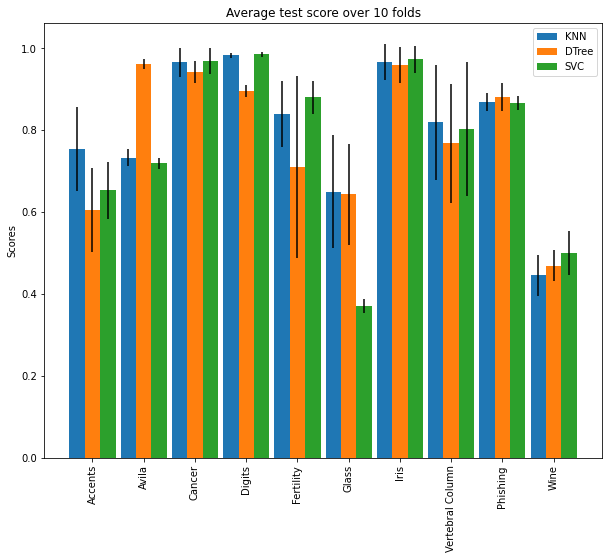

In [38]:
x = np.arange(len(dfs)*2, step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width, average_knn_scores, width, label='KNN', yerr=knn_score_std)
ax.bar(x, average_dtree_scores, width, label='DTree', yerr=dtree_score_std)
ax.bar(x + width, average_svc_scores, width, label='SVC', yerr=svc_score_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average test score over 10 folds')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

### 2.2 Aplicar Bagging a los clasificadores

Usamos un 70% de los patrones en cada estimador del _ensemble_ para que sean distintos.

In [33]:
knn_bagging = ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=.7, n_estimators=5, random_state=0)
dtree_bagging = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=.7, n_estimators=5, random_state=0)
svc_bagging = ensemble.BaggingClassifier(svm.SVC(), max_samples=.7, n_estimators=5, random_state=0)

In [34]:
knn_bagging_scores = np.empty((len(dfs), 10))
svc_bagging_scores = np.empty((len(dfs), 10))
dtree_bagging_scores = np.empty((len(dfs), 10))


for i in range(len(dfs)):
    print('['+'='*(i)+'>'+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)
    knn_bagging_scores[i] = model_selection.cross_val_score(knn_bagging, X[i], y[i], cv=10)
    svc_bagging_scores[i] = model_selection.cross_val_score(svc_bagging, X[i], y[i], cv=10)
    dtree_bagging_scores[i] = model_selection.cross_val_score(dtree_bagging ,X[i], y[i], cv=10)
    print('['+'='*(i+1)+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)

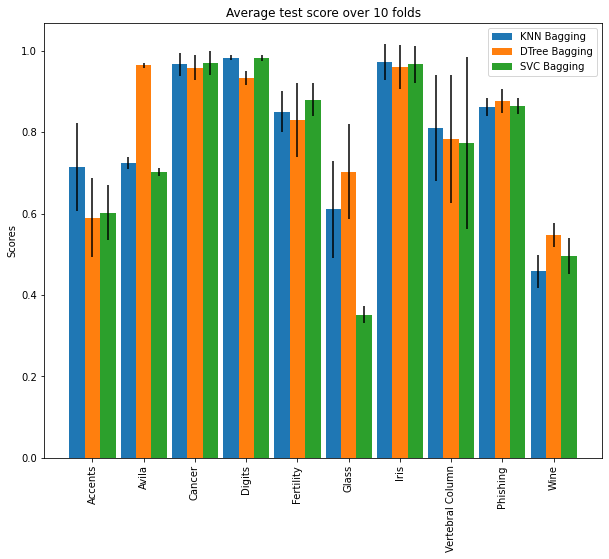

In [39]:
average_knn_b_scores = np.array([np.mean(x) for x in knn_bagging_scores])
knn_b_score_std = np.array([np.std(x) for x in knn_bagging_scores])

average_dtree_b_scores = np.array([np.mean(x) for x in dtree_bagging_scores])
dtree_b_score_std = np.array([np.std(x) for x in dtree_bagging_scores])

average_svc_b_scores = np.array([np.mean(x) for x in svc_bagging_scores])
svc_b_score_std = np.array([np.std(x) for x in svc_bagging_scores])

x = np.arange(len(dfs)*2, step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width, average_knn_b_scores, width, label='KNN Bagging', yerr=knn_b_score_std)
ax.bar(x, average_dtree_b_scores, width, label='DTree Bagging', yerr=dtree_b_score_std)
ax.bar(x + width, average_svc_b_scores, width, label='SVC Bagging', yerr=svc_b_score_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average test score over 10 folds')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

In [48]:
knn_diff = average_knn_b_scores - average_knn_scores
svc_diff = average_svc_b_scores - average_svc_scores
dtree_diff = average_dtree_b_scores - average_dtree_scores

In [50]:
print('Average change in accuracy for each method:')
print(f'\t KNN: {np.mean(knn_diff):.4f} (with std. {np.std(knn_diff):.4f})')
print(f'\t SVC: {np.mean(svc_diff):.4f} (with std. {np.std(svc_diff):.4f})')
print(f'\t DTree: {np.mean(dtree_diff):.4f} (with std. {np.std(dtree_diff):.4f})')


Average change in accuracy for each method:
	 KNN: -0.0075 (with std. 0.0174)
	 SVC: -0.0131 (with std. 0.0159)
	 DTree: 0.0313 (with std. 0.0407)


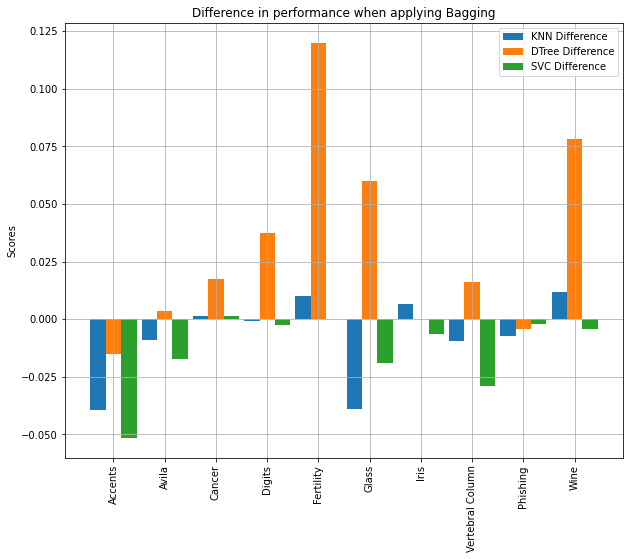

In [53]:
x = np.arange(len(dfs)*2, step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width, knn_diff, width, label='KNN Difference')
ax.bar(x, dtree_diff, width, label='DTree Difference')
ax.bar(x + width, svc_diff, width, label='SVC Difference')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.grid()
ax.set_ylabel('Scores')
ax.set_title('Difference in performance when applying Bagging')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

### 2.3 Aplicar algoritmos de _boosting_

Usaremos AdaBoost y GradientTree, implementados en scikit.

In [54]:
ada = ensemble.AdaBoostClassifier(random_state=0)
gtree = ensemble.GradientBoostingClassifier(random_state=0)

In [55]:
ada_scores = np.empty((len(dfs), 10))
gradient_scores = np.empty((len(dfs), 10))



for i in range(len(dfs)):
    print('['+'='*(i)+'>'+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)
    ada_scores[i] = model_selection.cross_val_score(ada, X[i], y[i], cv=10)
    gradient_scores[i] = model_selection.cross_val_score(gtree, X[i], y[i], cv=10)
    print('['+'='*(i+1)+(len(dfs)-i-1)*'.'+']', end='\r', flush=True)

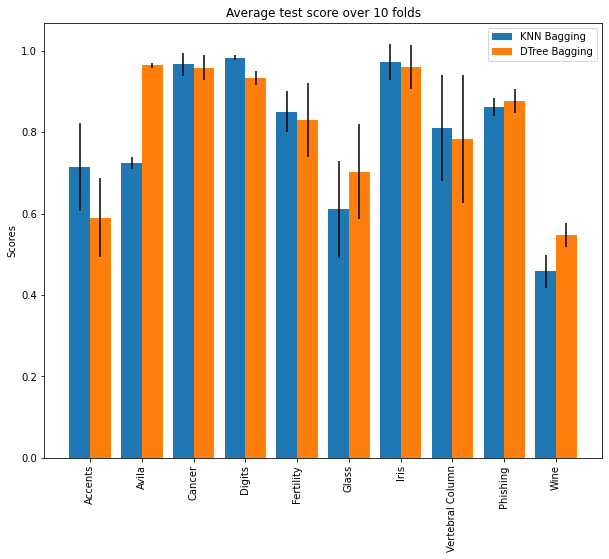

In [60]:
average_ada_scores = np.array([np.mean(x) for x in ada_scores])
ada_score_std = np.array([np.std(x) for x in ada_scores])

average_gtree_scores = np.array([np.mean(x) for x in gradient_scores])
gtree_score_std = np.array([np.std(x) for x in gradient_scores])


x = np.arange(len(dfs))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x - width/2, average_knn_b_scores, width, label='KNN Bagging', yerr=knn_b_score_std)
ax.bar(x + width/2, average_dtree_b_scores, width, label='DTree Bagging', yerr=dtree_b_score_std)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average test score over 10 folds')
ax.set_xticks(x)
ax.set_xticklabels(df_names, rotation='vertical')
ax.legend()

plt.show()

## 3. Conclusiones

Podemos ver cómo el _ensemble_ proporciona resultados positivos cuando el clasificador base es Decision Tree. Esto se debe a que KNN y SVM son métodos muy estables, en los que cada modelo del ensemble proporciona resultados muy similares.